In [1]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
import numpy as np
import tensorflow as tf
import keras
from keras import layers
%matplotlib inline

Shape of the content image:  (400, 400, 3)
Shape of the style image:  (400, 400, 3)


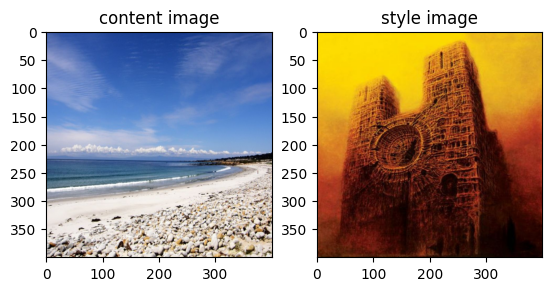

In [50]:
img_size = 400
content_image = np.array(Image.open("beach.jpg").resize((img_size, img_size)))
style_image = np.array(Image.open("beksinski.jpg").resize((img_size, img_size)))

print("Shape of the content image: ", content_image.shape)
print("Shape of the style image: ", style_image.shape)

plt.subplot(1,2,1)
plt.imshow(content_image)
plt.title('content image')
plt.subplot(1,2,2)
plt.imshow(style_image)
plt.title('style image')

# convert images to tensors 0-1
content_tensor = tf.image.convert_image_dtype(tf.constant(np.expand_dims(content_image, axis=0)), dtype=tf.float32)
style_tensor = tf.image.convert_image_dtype(tf.constant(np.expand_dims(style_image, axis=0)), dtype=tf.float32)

In [51]:
# download the model
vgg = tf.keras.applications.VGG19(
    include_top=False,
    weights='imagenet',
    input_shape=(img_size, img_size, 3)
)
vgg.trainable = False

In [52]:
vgg.input

<KerasTensor: shape=(None, 400, 400, 3) dtype=float32 (created by layer 'input_2')>

In [53]:
for layer in vgg.layers:
  print(layer.name)
  print(layer.output)

input_2
KerasTensor(type_spec=TensorSpec(shape=(None, 400, 400, 3), dtype=tf.float32, name='input_2'), name='input_2', description="created by layer 'input_2'")
block1_conv1
KerasTensor(type_spec=TensorSpec(shape=(None, 400, 400, 64), dtype=tf.float32, name=None), name='block1_conv1/Relu:0', description="created by layer 'block1_conv1'")
block1_conv2
KerasTensor(type_spec=TensorSpec(shape=(None, 400, 400, 64), dtype=tf.float32, name=None), name='block1_conv2/Relu:0', description="created by layer 'block1_conv2'")
block1_pool
KerasTensor(type_spec=TensorSpec(shape=(None, 200, 200, 64), dtype=tf.float32, name=None), name='block1_pool/MaxPool:0', description="created by layer 'block1_pool'")
block2_conv1
KerasTensor(type_spec=TensorSpec(shape=(None, 200, 200, 128), dtype=tf.float32, name=None), name='block2_conv1/Relu:0', description="created by layer 'block2_conv1'")
block2_conv2
KerasTensor(type_spec=TensorSpec(shape=(None, 200, 200, 128), dtype=tf.float32, name=None), name='block2_conv

In [54]:
content_layer = ['block5_conv4']
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

num_style_layers = len(style_layers)
print('Number of style layers:', num_style_layers)

Number of style layers: 5


In [55]:
vgg.input

<KerasTensor: shape=(None, 400, 400, 3) dtype=float32 (created by layer 'input_2')>

In [56]:
def get_model_outputs(layers):
  #vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet', input_shape=(img_size, img_size, 3))
  outputs = [vgg.get_layer(name).output for name in layers]
  model = tf.keras.Model([vgg.input], outputs)
  return model

In [57]:
content_extractor = get_model_outputs(content_layer) # a model
style_extractor = get_model_outputs(style_layers) # a model

(1, 400, 400, 3)


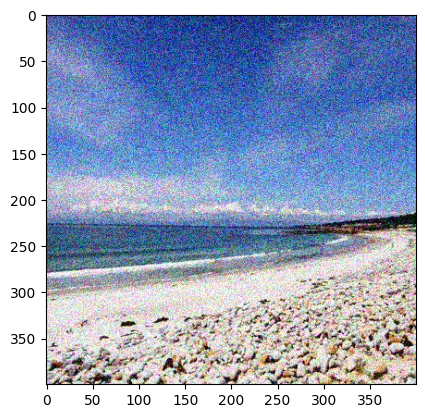

In [58]:
generated_image = tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
noise = tf.random.uniform(tf.shape(generated_image), -0.25, 0.25)
generated_image = tf.add(generated_image, noise)
generated_image = tf.clip_by_value(generated_image, clip_value_min=0.0, clip_value_max=1.0)
generated_image = tf.Variable(np.expand_dims(generated_image, axis=0))
print(generated_image.shape)
plt.imshow(generated_image.numpy()[0])

In [59]:
content_output = content_extractor(content_tensor)
style_output = style_extractor(style_tensor)

print("Shape of the content_output tensor:", content_output.shape)
for name, output in zip(style_layers, style_output):
  print("Shape of the ", name, " from the style_output tensor: ", output.shape)

Shape of the content_output tensor: (1, 25, 25, 512)
Shape of the  block1_conv1  from the style_output tensor:  (1, 400, 400, 64)
Shape of the  block2_conv1  from the style_output tensor:  (1, 200, 200, 128)
Shape of the  block3_conv1  from the style_output tensor:  (1, 100, 100, 256)
Shape of the  block4_conv1  from the style_output tensor:  (1, 50, 50, 512)
Shape of the  block5_conv1  from the style_output tensor:  (1, 25, 25, 512)



$$J_{content}(C,G) =  \frac{1}{4 \times n_H \times n_W \times n_C}\sum _{ \text{all entries}} (a^{(C)} - a^{(G)})^2\tag{1} $$
$$J_{style}^{[l]}(S,G) = \frac{1}{4 \times {n_C}^2 \times (n_H \times n_W)^2} \sum _{i=1}^{n_C}\sum_{j=1}^{n_C}(G^{(S)}_{(gram)i,j} - G^{(G)}_{(gram)i,j})^2\tag{2} $$
$$J_{style}(S,G) = \sum_{l} \lambda^{[l]} J^{[l]}_{style}(S,G)$$
$$J(G) = \alpha J_{content}(C,G) + \beta J_{style}(S,G)$$

In [60]:
def gram_matrix(A):
  """
  A - has to be a tensor of shape (n_channels , n_height*n_width)
  """
  GA = tf.linalg.matmul(A, A, transpose_b=True)
  return GA

In [61]:
#def create_generated_image(content_tensor, style_tensor):
#  a = tf.image.convert_image_dtype(content_tensor, tf.float32)
#  b = tf.image.convert_image_dtype(style_tensor, tf.float32)
#  c = np.squeeze(((a+b)/2.).numpy(), axis=0)
#  return c

#generated_image = create_generated_image(content_tensor, style_tensor)
#plt.imshow(generated_image)

In [62]:
#generated_image = tf.constant(np.expand_dims(generated_image, axis=0))

In [63]:
#generated_image = tf.random.uniform(shape=content_tensor.shape, minval=0., maxval=1.)
#plt.imshow(generated_image.numpy()[0])

In [64]:
def clip_0_1(image):
    """
    Truncate all the pixels in the tensor to be between 0 and 1

    Arguments:
    image -- Tensor
    J_style -- style cost coded above

    Returns:
    Tensor
    """
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [65]:
def tensor_to_image(tensor):
    """
    Converts the given tensor into a PIL image

    Arguments:
    tensor -- Tensor

    Returns:
    Image: A PIL image
    """
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return Image.fromarray(tensor)

In [66]:
# TODO: sytle cost function
def compute_content_cost(a_C, a_G):
  """
  Computes the content cost

  Arguments:
  a_C -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image C
  a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image G

  Returns:
  J_content -- scalar that you compute using equation 1 above.
  """
  #a_C = content_output
  #a_G = generated_output

  # Retrieve dimensions from a_G
  _, n_H, n_W, n_C = a_G.shape

  # Reshape a_C and a_G
  a_C_unrolled = tf.reshape(a_C, [n_H * n_W, n_C])
  a_G_unrolled = tf.reshape(a_G, [n_H * n_W, n_C])

  # compute the cost with tensorflow
  J_content = 1/(4 * n_H * n_W * n_C) * tf.math.reduce_sum(tf.math.square((a_C_unrolled-a_G_unrolled)))

  return J_content

In [67]:
def compute_layer_style_cost(a_S, a_G):
  """
  Arguments:
  a_S -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image S
  a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image G

  Returns:
  J_style_layer -- tensor representing a scalar value, style cost defined above by equation (2)
  """
  # Retrieve dimensions from a_G
  _, n_H, n_W, n_C = a_G.get_shape().as_list()

  # Reshape the images from (n_H * n_W, n_C) to have them of shape (n_C, n_H * n_W)
  a_S = tf.transpose(tf.reshape(a_S, shape=[-1, n_C]))
  a_G = tf.transpose(tf.reshape(a_G, shape=[-1, n_C]))

  # Computing gram_matrices for both images S and G
  GS = gram_matrix(a_S)
  GG = gram_matrix(a_G)

  # Computing the loss
  J_style_layer = (1/(4 * n_C**2 * (n_H * n_W)**2)) * tf.math.reduce_sum(tf.math.square(tf.math.subtract(GS,GG)))


  return J_style_layer

In [68]:
def compute_style_cost(style_image_output, generated_image_output, weight = 0.2, style_layers = style_layers):
  J_style = 0
  weights = [weight for i in range(0, len(style_layers))]

  for a_S, a_G, weight in zip(style_image_output, generated_image_output, weights):
    J_style += weight * compute_layer_style_cost(a_S, a_G)

  return J_style

In [69]:
# TODO: put it all together to get J(G) = alpha*J(C,G) + beta*J(S,G)
@tf.function()
def total_cost(J_content, J_style, alpha = 10, beta = 40):
    """
    Computes the total cost function

    Arguments:
    J_content -- content cost coded above
    J_style -- style cost coded above
    alpha -- hyperparameter weighting the importance of the content cost
    beta -- hyperparameter weighting the importance of the style cost

    Returns:
    J -- total cost as defined by the formula above.
    """

    J = alpha * J_content + beta * J_style

    return J

In [70]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.02)

@tf.function
def train_step(generated_image):
    with tf.GradientTape() as tape:
        # In this function you must use the precomputed encoded images a_S and a_C
        # Compute a_G as the vgg_model_outputs for the current generated image

        a_G1 = content_extractor(generated_image)
        a_G2 = style_extractor(generated_image)

        # Compute the style cost
        J_style = compute_style_cost(style_output, a_G2)

        # Compute the content cost
        J_content = compute_content_cost(content_output, a_G1)

        # Compute the total cost
        J = total_cost(J_content, J_style, alpha = 10, beta = 40)

    grad = tape.gradient(J, generated_image)
    if grad is None:
        print("Gradient is None!")
    else:
      optimizer.apply_gradients([(grad, generated_image)])
      generated_image.assign(clip_0_1(generated_image))

    return J

In [71]:
generated_image = tf.Variable(generated_image, trainable=True)
#J1 = train_step(generated_image)
#print(J1)

  0%|          | 0/1001 [00:00<?, ?it/s]

Epoch 0: Total Loss = 31063.5703125


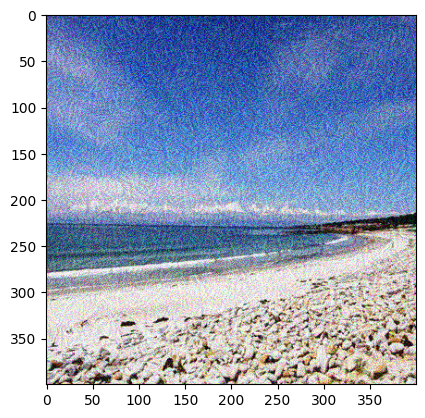

  3%|▎         | 26/1001 [00:24<14:19,  1.13it/s]

Epoch 25: Total Loss = 1295.874755859375


  5%|▌         | 51/1001 [00:46<14:04,  1.13it/s]

Epoch 50: Total Loss = 392.6217956542969


  8%|▊         | 76/1001 [01:08<13:34,  1.14it/s]

Epoch 75: Total Loss = 205.97830200195312


 10%|█         | 101/1001 [01:29<12:50,  1.17it/s]

Epoch 100: Total Loss = 141.1300048828125


 13%|█▎        | 126/1001 [01:51<13:01,  1.12it/s]

Epoch 125: Total Loss = 109.08226013183594


 15%|█▌        | 151/1001 [02:13<12:24,  1.14it/s]

Epoch 150: Total Loss = 89.85121154785156


 18%|█▊        | 176/1001 [02:36<12:46,  1.08it/s]

Epoch 175: Total Loss = 76.901123046875


 20%|██        | 201/1001 [02:58<11:57,  1.11it/s]

Epoch 200: Total Loss = 67.53710174560547


 23%|██▎       | 226/1001 [03:21<11:45,  1.10it/s]

Epoch 225: Total Loss = 60.4467887878418


 25%|██▍       | 250/1001 [03:43<11:15,  1.11it/s]

Epoch 250: Total Loss = 54.89606857299805


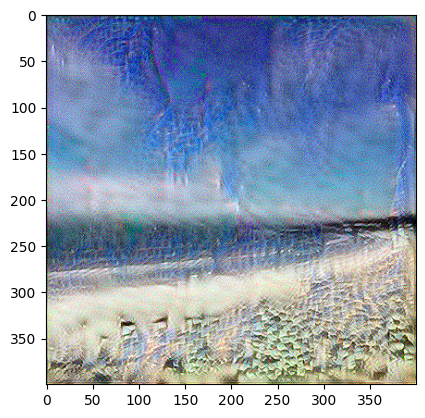

 28%|██▊       | 276/1001 [04:06<10:57,  1.10it/s]

Epoch 275: Total Loss = 50.44762420654297


 30%|███       | 301/1001 [04:28<10:47,  1.08it/s]

Epoch 300: Total Loss = 46.7684326171875


 33%|███▎      | 326/1001 [04:51<09:56,  1.13it/s]

Epoch 325: Total Loss = 43.67288589477539


 35%|███▌      | 351/1001 [05:13<09:40,  1.12it/s]

Epoch 350: Total Loss = 41.03262710571289


 38%|███▊      | 376/1001 [05:35<09:06,  1.14it/s]

Epoch 375: Total Loss = 38.74193572998047


 40%|████      | 401/1001 [05:58<08:52,  1.13it/s]

Epoch 400: Total Loss = 36.72547149658203


 43%|████▎     | 426/1001 [06:20<08:33,  1.12it/s]

Epoch 425: Total Loss = 34.931785583496094


 45%|████▌     | 451/1001 [06:42<08:15,  1.11it/s]

Epoch 450: Total Loss = 33.3617057800293


 48%|████▊     | 476/1001 [07:05<07:47,  1.12it/s]

Epoch 475: Total Loss = 32.101749420166016


 50%|████▉     | 500/1001 [07:26<07:22,  1.13it/s]

Epoch 500: Total Loss = 31.176355361938477


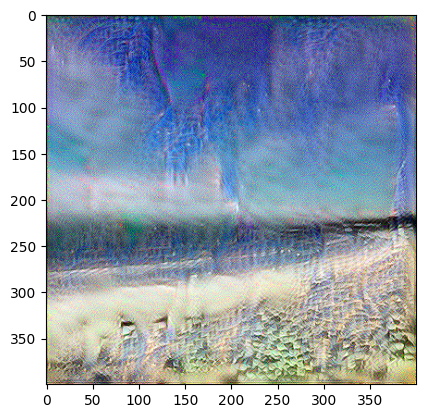

 53%|█████▎    | 526/1001 [07:49<07:10,  1.10it/s]

Epoch 525: Total Loss = 30.09206771850586


 55%|█████▌    | 551/1001 [08:12<06:34,  1.14it/s]

Epoch 550: Total Loss = 29.001178741455078


 58%|█████▊    | 576/1001 [08:34<06:24,  1.10it/s]

Epoch 575: Total Loss = 28.01270294189453


 60%|██████    | 601/1001 [08:57<05:52,  1.13it/s]

Epoch 600: Total Loss = 27.078378677368164


 63%|██████▎   | 626/1001 [09:19<05:29,  1.14it/s]

Epoch 625: Total Loss = 26.275646209716797


 65%|██████▌   | 651/1001 [09:41<05:06,  1.14it/s]

Epoch 650: Total Loss = 26.49090576171875


 68%|██████▊   | 676/1001 [10:03<04:50,  1.12it/s]

Epoch 675: Total Loss = 24.57442855834961


 70%|███████   | 701/1001 [10:25<04:26,  1.13it/s]

Epoch 700: Total Loss = 25.05100440979004


 73%|███████▎  | 726/1001 [10:47<03:56,  1.16it/s]

Epoch 725: Total Loss = 24.18855857849121


 75%|███████▍  | 750/1001 [11:08<03:44,  1.12it/s]

Epoch 750: Total Loss = 22.356367111206055


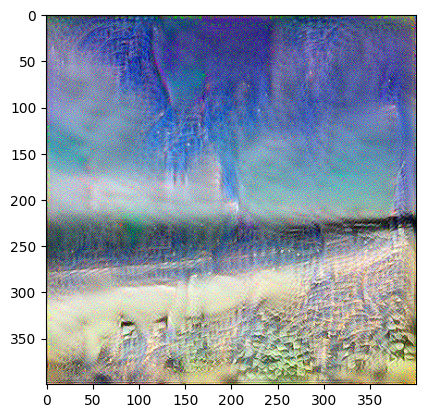

 78%|███████▊  | 776/1001 [11:32<03:19,  1.13it/s]

Epoch 775: Total Loss = 24.177635192871094


 80%|████████  | 801/1001 [11:54<03:00,  1.11it/s]

Epoch 800: Total Loss = 22.28943634033203


 83%|████████▎ | 826/1001 [12:16<02:32,  1.15it/s]

Epoch 825: Total Loss = 45.50519943237305


 85%|████████▌ | 851/1001 [12:38<02:12,  1.13it/s]

Epoch 850: Total Loss = 279.0539855957031


 88%|████████▊ | 876/1001 [13:00<01:47,  1.16it/s]

Epoch 875: Total Loss = 65.05854797363281


 90%|█████████ | 901/1001 [13:22<01:30,  1.11it/s]

Epoch 900: Total Loss = 38.467525482177734


 93%|█████████▎| 926/1001 [13:45<01:06,  1.14it/s]

Epoch 925: Total Loss = 30.400310516357422


 95%|█████████▌| 951/1001 [14:07<00:42,  1.16it/s]

Epoch 950: Total Loss = 27.331541061401367


 98%|█████████▊| 976/1001 [14:29<00:22,  1.12it/s]

Epoch 975: Total Loss = 24.59800148010254


100%|█████████▉| 1000/1001 [14:50<00:00,  1.13it/s]

Epoch 1000: Total Loss = 22.876890182495117


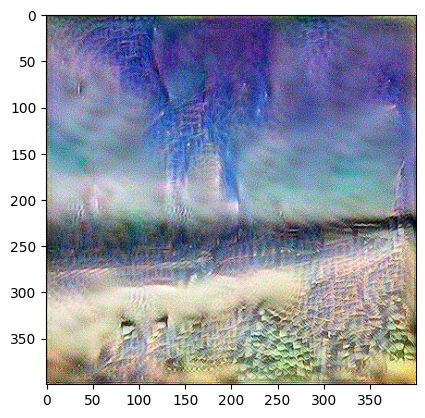

100%|██████████| 1001/1001 [14:51<00:00,  1.12it/s]


In [72]:
import tqdm
epochs = 1001
for i in tqdm.tqdm(range(epochs)):
    J = train_step(generated_image)
    # Debugging loss values
    if i % 25 == 0:
        print(f"Epoch {i}: Total Loss = {J.numpy()}")
    #if i % 250 == 0:
    #    print(f"Epoch {i} ")
    if i % 250 == 0:
        image = tensor_to_image(generated_image)
        imshow(image)
        image.save(f"image_2{i}.jpg")
        plt.show()

In [ ]:

plt.subplot(1,4,1)
plt.imshow(vgg(content_image).numpy()[0,:,:,0])
plt.subplot(1,4,2)
plt.imshow(vgg(content_image).numpy()[0,:,:,1])
plt.subplot(1,4,3)
plt.imshow(vgg(content_image).numpy()[0,:,:,2])
plt.subplot(1,4,4)
plt.imshow(vgg(content_image).numpy()[0,:,:,3])